# **3D Head and Neck Tumor Segmentation (HNTS) using 3D Swin UNETR**

**Import necessary libraries**

In [25]:
# Standard Library Imports
import os
import shutil
import tempfile
import urllib.request
import zipfile

# Data Processing & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

# PyTorch & Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Medical Imaging Libraries
import nibabel as nib

# MONAI (Medical Open Network for AI)
from monai.config import print_config
from monai.data import (
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    ThreadDataLoader,
)
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

**Seed for Reproducibility**

In [26]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# Apply seeding
set_seed(0)

**Paramters**

In [27]:
# Paths
DATA_PATH = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
ZIP_FILE = os.path.join(DATA_PATH, 'HNTSMRG24_train.zip')
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'
TRAIN_DIR = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# Training Parameters
BATCH_SIZE_TRAIN = 3               # Number of samples per training batch
NUM_WORKERS = 4                    # Number of subprocesses for data loading
NUM_EPOCHS = 250                    # Total number of training epochs
LEARNING_RATE = 5e-4               # Initial learning rate for optimizer
WEIGHT_DECAY = 1e-5                # Weight decay for optimizer
NUM_CLASSES = 3                    # Number of output classes (Background, GTVp, GTVn)
NUM_SAMPLES = 4                    # Number of samples
ACCUMULATION_STEPS = 4             # Gradient accumulation steps. Used for simulate larger batch

# Learning Rate Scheduler Parameters
SCHEDULER_FACTOR = 0.5             # Factor used to reduce learning rate
SCHEDULER_PATIENCE = 8             # Epochs without improvement before changing learning rate
SCHEDULER_MIN_LR = 1e-6            # Lowest possible learning rate

# Device Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# **Step 1: Load Data**

In [28]:
def extract_data(zip_file, extract_path):
    """
    Extracts preRT files from the dataset zip.
    """

    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
        zip_ref.extractall(path=extract_path, members=preRT_files)
    print(f"Data extracted to {extract_path}")

# Extract data
extract_data(ZIP_FILE, EXTRACTED_PATH)

Data extracted to /cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data


# **Step 2: Exploratory Data Analysis**

**Count number of patients**

In [29]:
# Path to the training data
train_dir = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(TRAIN_DIR)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


**Prepare EDA**

In [30]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders:

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))

**EDA: Image Dimensions**

In [31]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

# Create a DataFrame for the results
data = {
    "Statistic": ["Minimum", "Maximum", "Mean (rounded)"],
    "Width": [min_dims[0], max_dims[0], mean_dims[0]],
    "Height": [min_dims[1], max_dims[1], mean_dims[1]],
    "Depth": [min_dims[2], max_dims[2], mean_dims[2]]
}

# Display as dataframe
pd.DataFrame(data)

,Statistic,Width,Height,Depth
0,Minimum,512.000000,480.00,57.00
1,Maximum,768.000000,768.00,162.00
2,Mean (rounded),523.306667,522.88,84.04


**EDA: Tumor Sizes**

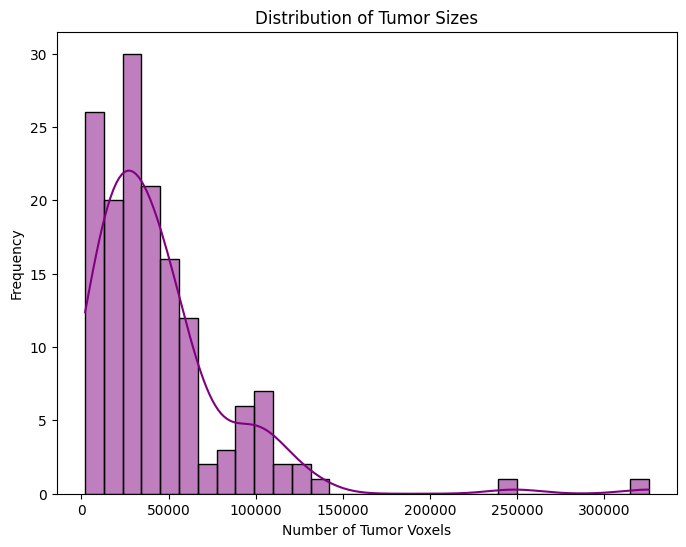

In [32]:
# Calculate tumor sizes
tumor_sizes = [counts.get(1, 0) + counts.get(2, 0) for counts in mask_voxel_counts]

# Plot distribution
plt.figure(figsize=(8, 6))
sns.histplot(tumor_sizes, bins=30, kde=True, color='purple')
plt.title('Distribution of Tumor Sizes')
plt.xlabel('Number of Tumor Voxels')
plt.ylabel('Frequency')
plt.show()

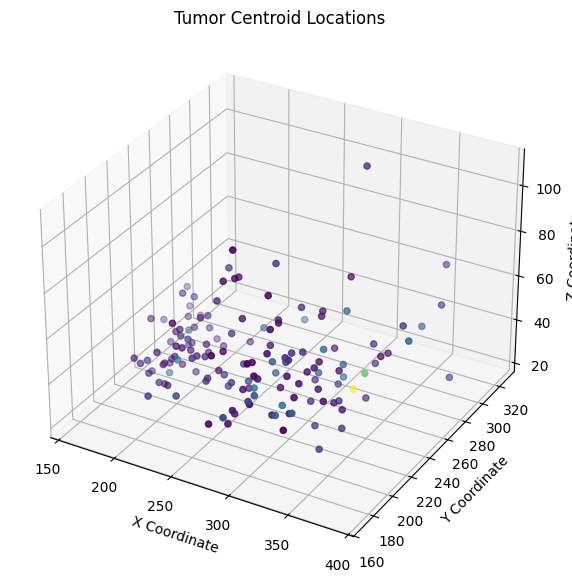

In [33]:
# Initialize lists
tumor_sizes = []
tumor_locations = []

for patient_id in patient_folders:
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(int)

    # Calculate tumor size (number of voxels in tumor classes)
    tumor_voxels = mask_data > 0
    size = np.sum(tumor_voxels)
    tumor_sizes.append(size)

    # Calculate tumor centroid
    coords = np.column_stack(np.where(mask_data > 0))
    if coords.size > 0:
        centroid = coords.mean(axis=0)
        tumor_locations.append(centroid)
    else:
        tumor_locations.append([np.nan, np.nan, np.nan])

# Convert to DataFrame
eda_df = pd.DataFrame({
    'Patient_ID': patient_folders,
    'Tumor_Size': tumor_sizes,
    'Centroid_X': [loc[0] for loc in tumor_locations],
    'Centroid_Y': [loc[1] for loc in tumor_locations],
    'Centroid_Z': [loc[2] for loc in tumor_locations],
})

# 3D Scatter plot of tumor centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eda_df['Centroid_X'], eda_df['Centroid_Y'], eda_df['Centroid_Z'], c=eda_df['Tumor_Size'])
ax.set_title('Tumor Centroid Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.show()

**EDA: Understand class distribution (Background, GTVp, GTVn)**

In [34]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

# Define class labels
class_labels = {
    0: 'Background',
    1: 'GTVp',
    2: 'GTVn'
}

# Create a DataFrame for class distribution
class_df = pd.DataFrame({
    'Class': [class_labels.get(cls, f'Class {cls}') for cls in class_percentages.keys()],
    'Percentage (%)': [round(pct, 4) for pct in class_percentages.values()]
})

# Display the DataFrame
class_df

,Class,Percentage (%)
0,Background,99.8107
1,GTVp,0.0862
2,GTVn,0.1031


**EDA: Plot samples to check quality and type of data**

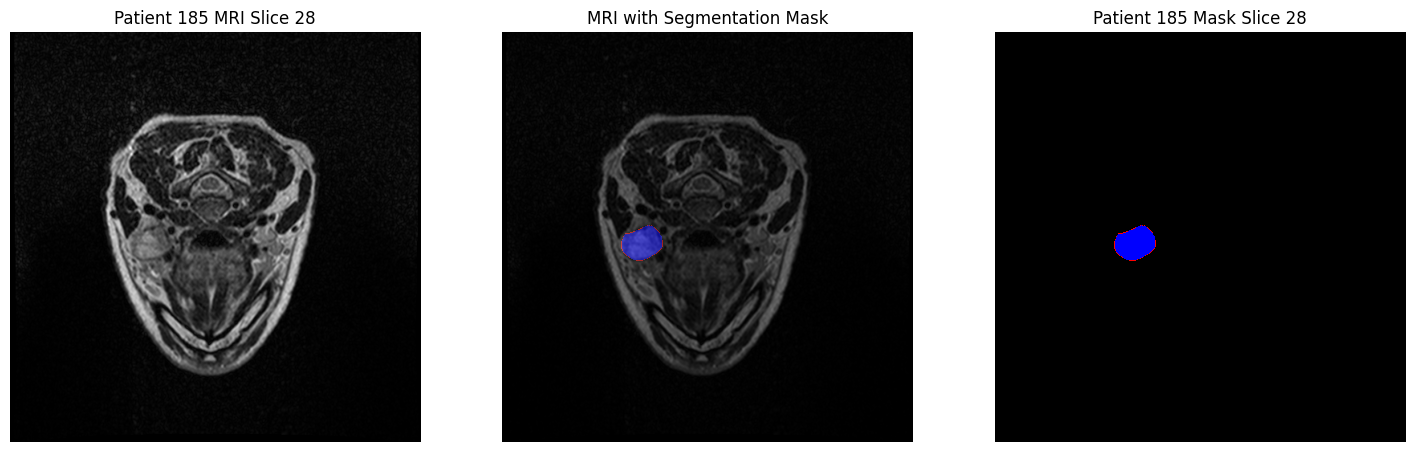

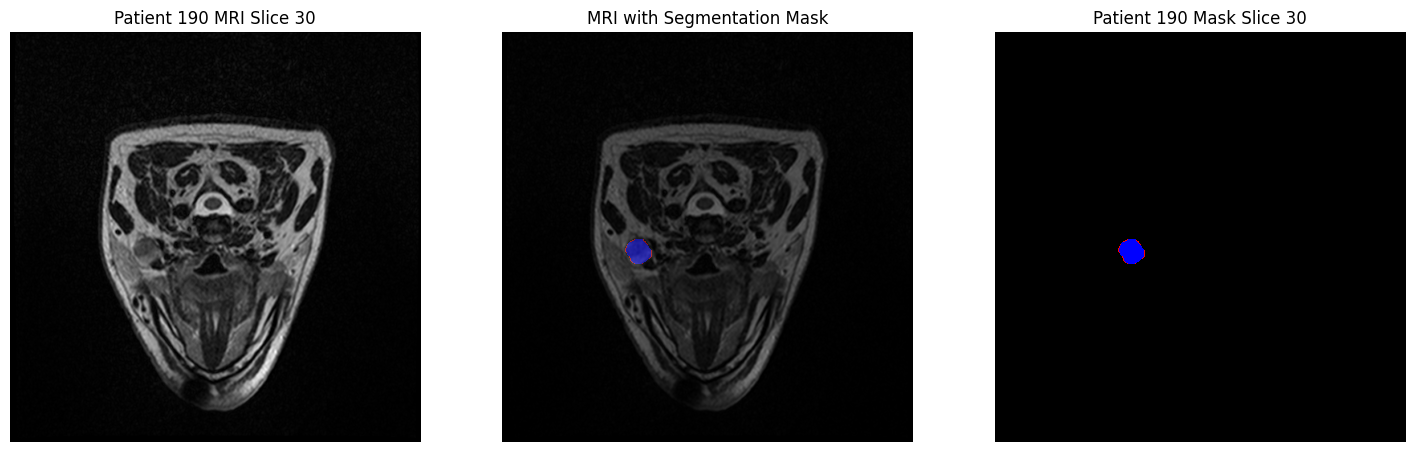

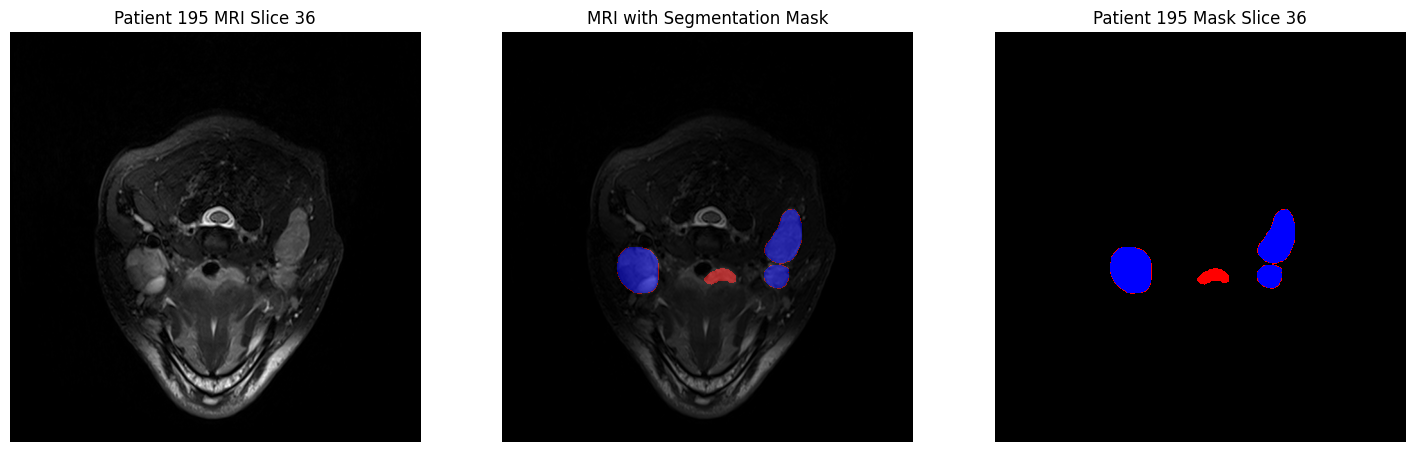

In [35]:
def plot_sample(patient_id, slice_index=None):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select the middle slice
    slice_index = mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. MRI Image
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].set_title(f'Patient {patient_id} MRI Slice {slice_index}')
    axes[0].axis('off')
    
    # 2. MRI with Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')
    
    # 3. Mask Only
    im = axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Mask Slice {slice_index}')
    axes[2].axis('off')

    plt.show()

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

**Create data dictionary**

In [36]:
def create_data_dicts(train_dir):
    """
    Creates data dictionaries for MONAI.
    """
    data_dicts = [
        {
            "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
            "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
        }
        for pid in patient_folders
    ]
    return data_dicts

# Create data dictionaries
data_dicts = create_data_dicts(TRAIN_DIR)

**Split the dataset into training and validation (80/20)**

In [37]:
# Split data into training and validation sets
train_files = data_dicts[:120]
val_files = data_dicts[120:]
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 120, Validation samples: 30


**Transform images**

In [38]:
# Transform the images for training
train_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
            ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),

        # Randomly crop based on labels
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=NUM_SAMPLES,
            image_key="image",
            image_threshold=0,
        ),
        
        # Apply random flips
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),

        # Apply random rotations
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),

        # Random intensity shift
        RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
    ]
)

# Transform the images for validation
val_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

**Create datasets**

In [39]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

Loading dataset: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]


**Create DataLoaders**

In [40]:
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=3, shuffle=True)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)


Train Batch 1:


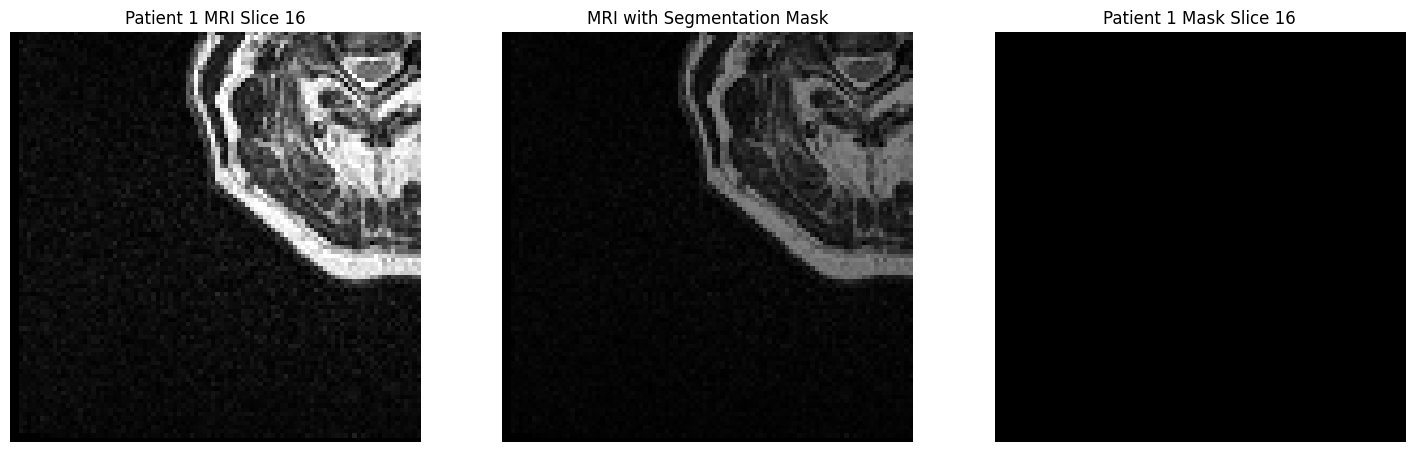

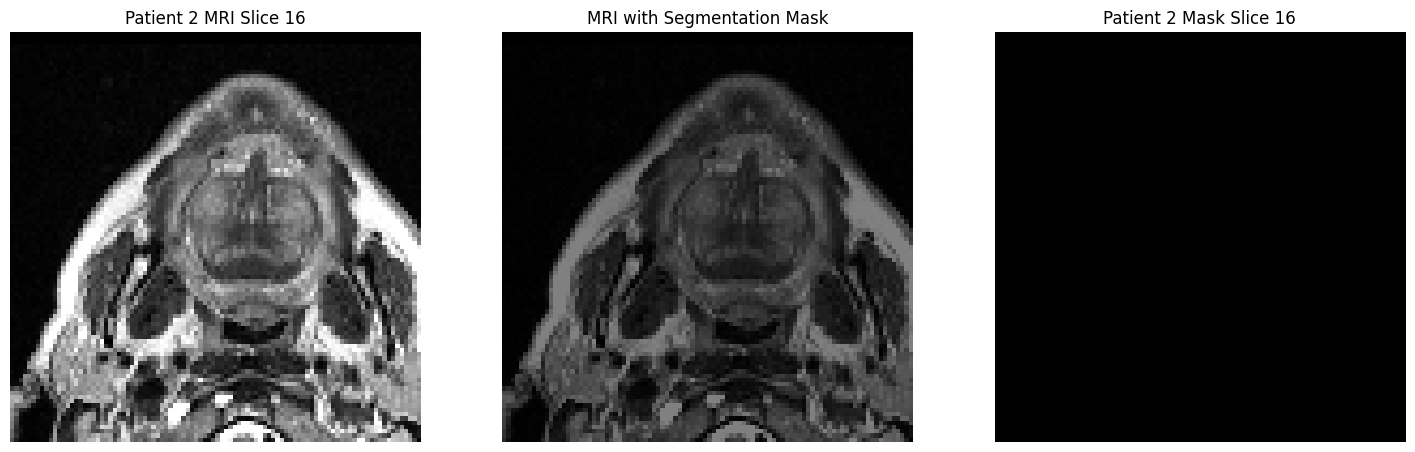


Train Batch 2:


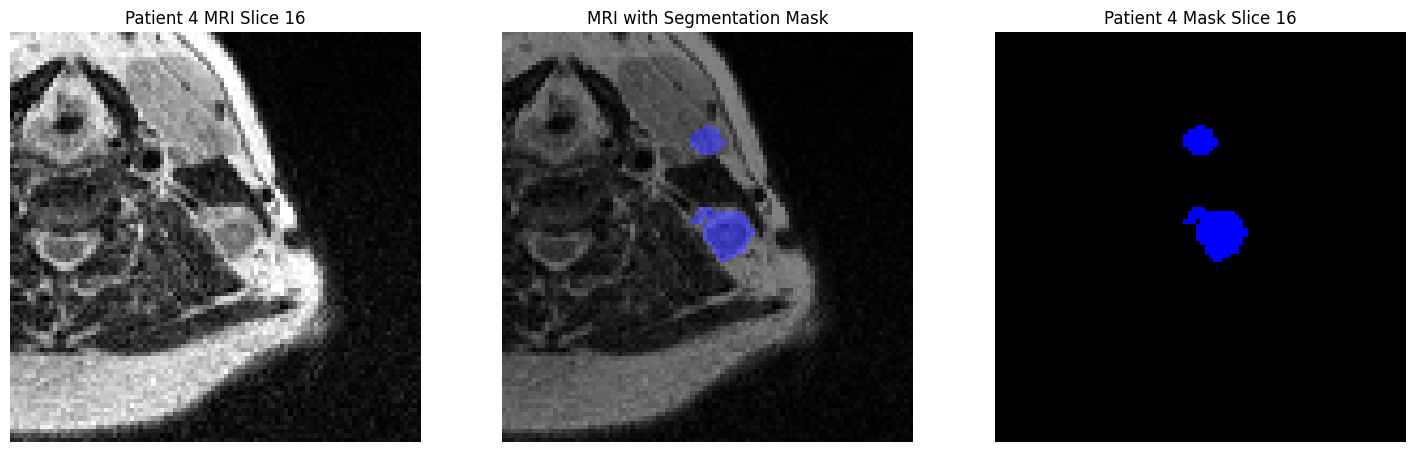

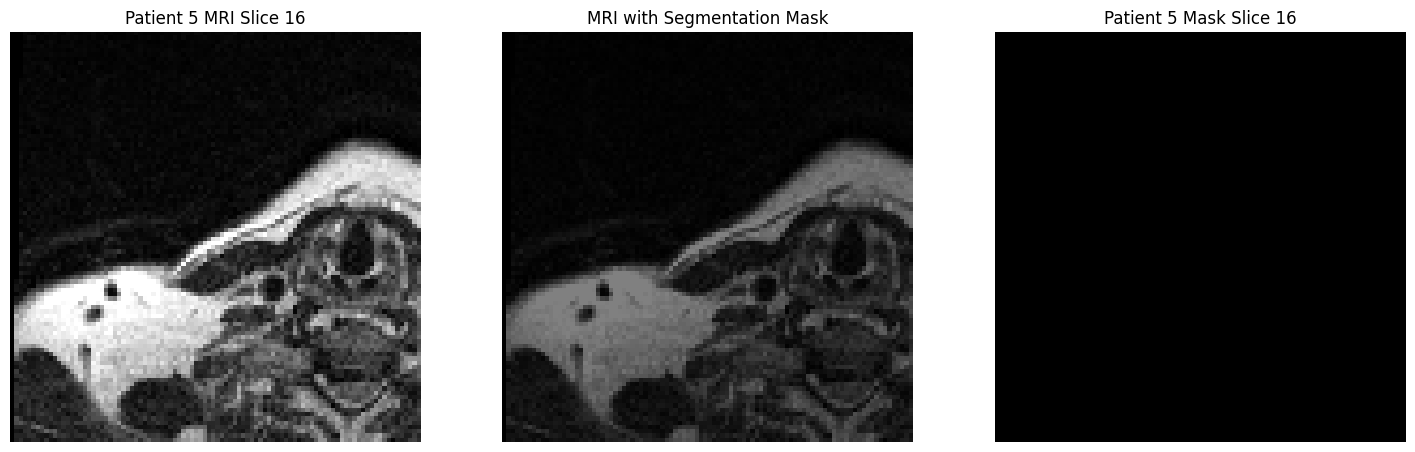


Validation Batch 1:


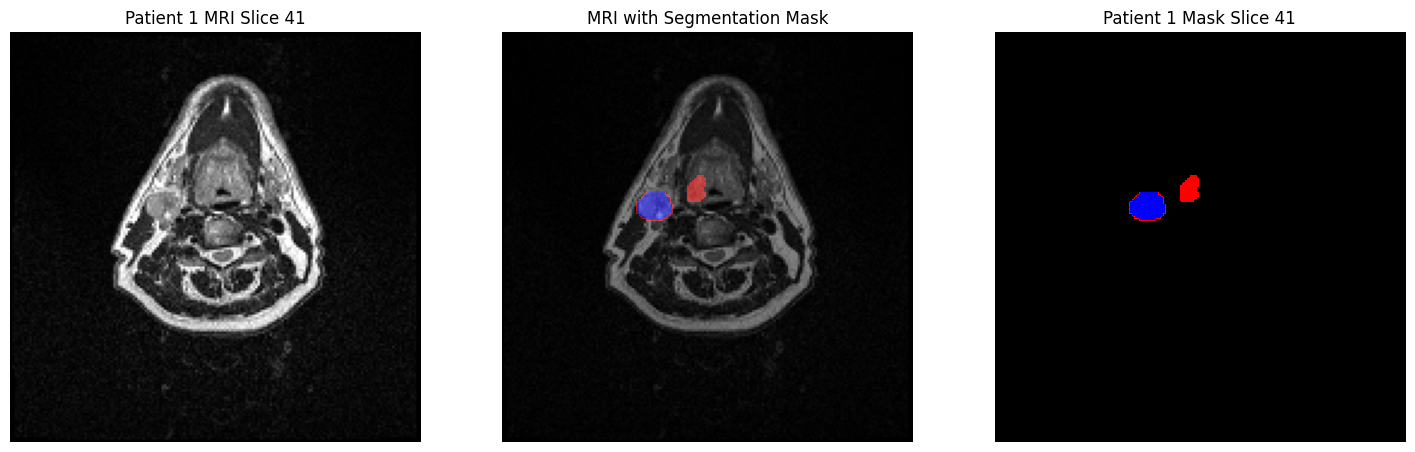

In [41]:
def plot_dataloader_sample(image_tensor, label_tensor, patient_id=None, slice_index=None):
    """
    Plots MRI image, MRI with segmentation mask overlay, and mask only.
    """
    image_np = image_tensor.cpu().numpy()
    label_np = label_tensor.cpu().numpy()

    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)

    if label_np.ndim == 4 and label_np.shape[0] == 1:
        label_np = np.squeeze(label_np, axis=0)

    if slice_index is None:
        slice_index = image_np.shape[2] // 2

    mri_slice = image_np[:, :, slice_index].T
    mask_slice = label_np[:, :, slice_index].T

    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    title1 = f'Patient {patient_id} MRI Slice {slice_index}' if patient_id else f'MRI Slice {slice_index}'
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')

    axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    title3 = f'Patient {patient_id} Mask Slice {slice_index}' if patient_id else f'Mask Slice {slice_index}'
    axes[2].set_title(title3)
    axes[2].axis('off')

    plt.show()

def visualize_dataloader_samples(dataloader, num_batches=1, samples_per_batch=2, mode='Train'):
    """
    Visualizes samples from the dataloader.
    """
    for batch_idx, batch_data in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        images = batch_data["image"]
        labels = batch_data["label"]

        batch_size = images.shape[0]
        print(f"\n{mode} Batch {batch_idx + 1}:")
        for i in range(min(samples_per_batch, batch_size)):
            image = images[i]
            label = labels[i]
            patient_id = f"{batch_idx * dataloader.batch_size + i + 1}"
            plot_dataloader_sample(image, label, patient_id=patient_id)

# Example visualization
visualize_dataloader_samples(train_loader, num_batches=2, samples_per_batch=2, mode='Train')
visualize_dataloader_samples(val_loader, num_batches=1, samples_per_batch=1, mode='Validation')

**Prepare for usage of GPU**

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Step 5: Build Model**

**Initialize UNET Model**

In [43]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides= (2, 2, 2, 2, 2),
    num_res_units=5,
    dropout=0.3,
    norm=Norm.BATCH,
).to(device)

# **Step 6: Train and Validate Model**

**Define Loss, Optimizer, and Metrics**

In [44]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

post_label = AsDiscrete(to_onehot=NUM_CLASSES)
post_pred = AsDiscrete(argmax=True, to_onehot=NUM_CLASSES)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

**Training Loop**

In [45]:
# Post-processing for metrics
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

# Initialize Dice metric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Initialize lists to store loss values
train_losses = []
val_losses = []
dice_scores = []

best_dice = 0.0  # Initialize best Dice score
best_epoch = 0  # To track which epoch had the best Dice score

# Initialize the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Because higher Dice score is better
    factor=SCHEDULER_FACTOR,
    patience=SCHEDULER_PATIENCE,
    verbose=True,
    min_lr=SCHEDULER_MIN_LR
)

# Training Loop
for epoch in range(NUM_EPOCHS):

    # ----------- Training Phase -----------
    model.train()
    epoch_loss = 0.0
    step = 0
    progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_data in progress_bar:
        step += 1

        # Retrieve training samples
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.amp.autocast(str(device)):

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels) / ACCUMULATION_STEPS

        # Backward pass
        scaler.scale(loss).backward()

        # Calculate epoch loss
        epoch_loss += loss.item() * ACCUMULATION_STEPS

        if step % ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({"Loss": loss.item()*ACCUMULATION_STEPS})

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)


    # ----------- Validation Phase -----------
    model.eval()
    val_loss = 0.0
    dice_metric.reset()
    progress_bar = tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{NUM_EPOCHS}")

    with torch.no_grad():
        for val_batch in progress_bar:

            # Retrieve validation samples
            val_inputs = val_batch["image"].cuda()
            val_labels = val_batch["label"].cuda()

            with torch.amp.autocast(str(device)):
                # Forward pass with sliding window inference for large images
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)

                if torch.isnan(val_outputs).any():
                    print("NaN detected in model outputs")

                # Compute validation loss
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()

            # Post-processing for Dice metric
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)

            # Update progress bar
            progress_bar.set_postfix({"Loss": loss.item()})
    
    # Calculate average validation loss and Dice score for the epoch
    avg_val_loss = val_loss / len(val_loader)
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()

    # Save losses
    val_losses.append(avg_val_loss)
    dice_scores.append(dice_score)

    # Step the scheduler based on validation Dice score
    scheduler.step(dice_score)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_epoch_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Dice Score: {dice_score:.4f}")


    # ----------- Model Checkpointing -----------
    if dice_score > best_dice:
        best_dice = dice_score
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"New best Dice score! Model saved at epoch {best_epoch} with Dice: {best_dice:.4f}")
    else:
        print(f"No improvement in Dice score this epoch.")


Validation epoch 1/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.768]


Epoch [1/250], Train Loss: 0.8001, Val Loss: 0.7749, Dice Score: 0.3464
New best Dice score! Model saved at epoch 1 with Dice: 0.3464


Validation epoch 2/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.762]


Epoch [2/250], Train Loss: 0.7730, Val Loss: 0.7659, Dice Score: 0.3567
New best Dice score! Model saved at epoch 2 with Dice: 0.3567


Validation epoch 3/250: 100%|██████████| 30/30 [00:02<00:00, 14.12it/s, Loss=0.741]


Epoch [3/250], Train Loss: 0.7557, Val Loss: 0.7438, Dice Score: 0.3646
New best Dice score! Model saved at epoch 3 with Dice: 0.3646


Validation epoch 4/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.72] 


Epoch [4/250], Train Loss: 0.7411, Val Loss: 0.7256, Dice Score: 0.3625
No improvement in Dice score this epoch.


Validation epoch 5/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.708]


Epoch [5/250], Train Loss: 0.7293, Val Loss: 0.7112, Dice Score: 0.3655
New best Dice score! Model saved at epoch 5 with Dice: 0.3655


Validation epoch 6/250: 100%|██████████| 30/30 [00:02<00:00, 14.14it/s, Loss=0.701]


Epoch [6/250], Train Loss: 0.7195, Val Loss: 0.7028, Dice Score: 0.3691
New best Dice score! Model saved at epoch 6 with Dice: 0.3691


Validation epoch 7/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.693]


Epoch [7/250], Train Loss: 0.7111, Val Loss: 0.6951, Dice Score: 0.3684
No improvement in Dice score this epoch.


Validation epoch 8/250: 100%|██████████| 30/30 [00:02<00:00, 14.03it/s, Loss=0.691]


Epoch [8/250], Train Loss: 0.7041, Val Loss: 0.6912, Dice Score: 0.3748
New best Dice score! Model saved at epoch 8 with Dice: 0.3748


Validation epoch 9/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.685]


Epoch [9/250], Train Loss: 0.6967, Val Loss: 0.6823, Dice Score: 0.3842
New best Dice score! Model saved at epoch 9 with Dice: 0.3842


Validation epoch 10/250: 100%|██████████| 30/30 [00:02<00:00, 14.15it/s, Loss=0.682]


Epoch [10/250], Train Loss: 0.6896, Val Loss: 0.6781, Dice Score: 0.3836
No improvement in Dice score this epoch.


Validation epoch 11/250: 100%|██████████| 30/30 [00:02<00:00, 13.99it/s, Loss=0.695]


Epoch [11/250], Train Loss: 0.6824, Val Loss: 0.6954, Dice Score: 0.3918
New best Dice score! Model saved at epoch 11 with Dice: 0.3918


Validation epoch 12/250: 100%|██████████| 30/30 [00:02<00:00, 14.00it/s, Loss=0.716]


Epoch [12/250], Train Loss: 0.6739, Val Loss: 0.7202, Dice Score: 0.3477
No improvement in Dice score this epoch.


Validation epoch 13/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.691]


Epoch [13/250], Train Loss: 0.6657, Val Loss: 0.6974, Dice Score: 0.3656
No improvement in Dice score this epoch.


Validation epoch 14/250: 100%|██████████| 30/30 [00:02<00:00, 14.04it/s, Loss=0.672]


Epoch [14/250], Train Loss: 0.6577, Val Loss: 0.6704, Dice Score: 0.3828
No improvement in Dice score this epoch.


Validation epoch 15/250: 100%|██████████| 30/30 [00:02<00:00, 14.03it/s, Loss=0.674]


Epoch [15/250], Train Loss: 0.6534, Val Loss: 0.6595, Dice Score: 0.3912
No improvement in Dice score this epoch.


Validation epoch 16/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.669]


Epoch [16/250], Train Loss: 0.6437, Val Loss: 0.6525, Dice Score: 0.4169
New best Dice score! Model saved at epoch 16 with Dice: 0.4169


Validation epoch 17/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.671]


Epoch [17/250], Train Loss: 0.6425, Val Loss: 0.6645, Dice Score: 0.3894
No improvement in Dice score this epoch.


Validation epoch 18/250: 100%|██████████| 30/30 [00:02<00:00, 14.14it/s, Loss=0.682]


Epoch [18/250], Train Loss: 0.6393, Val Loss: 0.6721, Dice Score: 0.3727
No improvement in Dice score this epoch.


Validation epoch 19/250: 100%|██████████| 30/30 [00:02<00:00, 14.14it/s, Loss=0.672]


Epoch [19/250], Train Loss: 0.6384, Val Loss: 0.6590, Dice Score: 0.4133
No improvement in Dice score this epoch.


Validation epoch 20/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.674]


Epoch [20/250], Train Loss: 0.6297, Val Loss: 0.6736, Dice Score: 0.3705
No improvement in Dice score this epoch.


Validation epoch 21/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.67] 


Epoch [21/250], Train Loss: 0.6307, Val Loss: 0.6715, Dice Score: 0.4049
No improvement in Dice score this epoch.


Validation epoch 22/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.666]


Epoch [22/250], Train Loss: 0.6264, Val Loss: 0.6384, Dice Score: 0.4203
New best Dice score! Model saved at epoch 22 with Dice: 0.4203


Validation epoch 23/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.671]


Epoch [23/250], Train Loss: 0.6152, Val Loss: 0.6622, Dice Score: 0.3966
No improvement in Dice score this epoch.


Validation epoch 24/250: 100%|██████████| 30/30 [00:02<00:00, 13.97it/s, Loss=0.676]


Epoch [24/250], Train Loss: 0.6215, Val Loss: 0.6632, Dice Score: 0.4075
No improvement in Dice score this epoch.


Validation epoch 25/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.66] 


Epoch [25/250], Train Loss: 0.6198, Val Loss: 0.6355, Dice Score: 0.4290
New best Dice score! Model saved at epoch 25 with Dice: 0.4290


Validation epoch 26/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.667]


Epoch [26/250], Train Loss: 0.6121, Val Loss: 0.6412, Dice Score: 0.4141
No improvement in Dice score this epoch.


Validation epoch 27/250: 100%|██████████| 30/30 [00:02<00:00, 14.03it/s, Loss=0.696]


Epoch [27/250], Train Loss: 0.6119, Val Loss: 0.6829, Dice Score: 0.3947
No improvement in Dice score this epoch.


Validation epoch 28/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.658]


Epoch [28/250], Train Loss: 0.6057, Val Loss: 0.6322, Dice Score: 0.4357
New best Dice score! Model saved at epoch 28 with Dice: 0.4357


Validation epoch 29/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.672]


Epoch [29/250], Train Loss: 0.6069, Val Loss: 0.6517, Dice Score: 0.4150
No improvement in Dice score this epoch.


Validation epoch 30/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.665]


Epoch [30/250], Train Loss: 0.6081, Val Loss: 0.6414, Dice Score: 0.4198
No improvement in Dice score this epoch.


Validation epoch 31/250: 100%|██████████| 30/30 [00:02<00:00, 14.14it/s, Loss=0.666]


Epoch [31/250], Train Loss: 0.5974, Val Loss: 0.6604, Dice Score: 0.3804
No improvement in Dice score this epoch.


Validation epoch 32/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.668]


Epoch [32/250], Train Loss: 0.5925, Val Loss: 0.6402, Dice Score: 0.4100
No improvement in Dice score this epoch.


Validation epoch 33/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.654]


Epoch [33/250], Train Loss: 0.5939, Val Loss: 0.6223, Dice Score: 0.4261
No improvement in Dice score this epoch.


Validation epoch 34/250: 100%|██████████| 30/30 [00:02<00:00, 14.14it/s, Loss=0.672]


Epoch [34/250], Train Loss: 0.5967, Val Loss: 0.6306, Dice Score: 0.4312
No improvement in Dice score this epoch.


Validation epoch 35/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.656]


Epoch [35/250], Train Loss: 0.5920, Val Loss: 0.6226, Dice Score: 0.4355
No improvement in Dice score this epoch.


Validation epoch 36/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.669]


Epoch [36/250], Train Loss: 0.5934, Val Loss: 0.6426, Dice Score: 0.4046
No improvement in Dice score this epoch.


Validation epoch 37/250: 100%|██████████| 30/30 [00:02<00:00, 13.97it/s, Loss=0.669]


Epoch [37/250], Train Loss: 0.5961, Val Loss: 0.6332, Dice Score: 0.4170
No improvement in Dice score this epoch.


Validation epoch 38/250: 100%|██████████| 30/30 [00:02<00:00, 14.04it/s, Loss=0.661]


Epoch [38/250], Train Loss: 0.5832, Val Loss: 0.6166, Dice Score: 0.4337
No improvement in Dice score this epoch.


Validation epoch 39/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.658]


Epoch [39/250], Train Loss: 0.5839, Val Loss: 0.6101, Dice Score: 0.4422
New best Dice score! Model saved at epoch 39 with Dice: 0.4422


Validation epoch 40/250: 100%|██████████| 30/30 [00:02<00:00, 14.04it/s, Loss=0.649]


Epoch [40/250], Train Loss: 0.5805, Val Loss: 0.5862, Dice Score: 0.4736
New best Dice score! Model saved at epoch 40 with Dice: 0.4736


Validation epoch 41/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.657]


Epoch [41/250], Train Loss: 0.5732, Val Loss: 0.6138, Dice Score: 0.4369
No improvement in Dice score this epoch.


Validation epoch 42/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.658]


Epoch [42/250], Train Loss: 0.5737, Val Loss: 0.6239, Dice Score: 0.4315
No improvement in Dice score this epoch.


Validation epoch 43/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.668]


Epoch [43/250], Train Loss: 0.5802, Val Loss: 0.6314, Dice Score: 0.4139
No improvement in Dice score this epoch.


Validation epoch 44/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.663]


Epoch [44/250], Train Loss: 0.5728, Val Loss: 0.6262, Dice Score: 0.4209
No improvement in Dice score this epoch.


Validation epoch 45/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.667]


Epoch [45/250], Train Loss: 0.5762, Val Loss: 0.5870, Dice Score: 0.4648
No improvement in Dice score this epoch.


Validation epoch 46/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.645]


Epoch [46/250], Train Loss: 0.5721, Val Loss: 0.5996, Dice Score: 0.4574
No improvement in Dice score this epoch.


Validation epoch 47/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.629]


Epoch [47/250], Train Loss: 0.5658, Val Loss: 0.5915, Dice Score: 0.4664
No improvement in Dice score this epoch.


Validation epoch 48/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.652]


Epoch [48/250], Train Loss: 0.5772, Val Loss: 0.5608, Dice Score: 0.4990
New best Dice score! Model saved at epoch 48 with Dice: 0.4990


Validation epoch 49/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.648]


Epoch [49/250], Train Loss: 0.5774, Val Loss: 0.5714, Dice Score: 0.4844
No improvement in Dice score this epoch.


Validation epoch 50/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.66] 


Epoch [50/250], Train Loss: 0.5649, Val Loss: 0.6008, Dice Score: 0.4528
No improvement in Dice score this epoch.


Validation epoch 51/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.646]


Epoch [51/250], Train Loss: 0.5718, Val Loss: 0.5784, Dice Score: 0.4743
No improvement in Dice score this epoch.


Validation epoch 52/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.65] 


Epoch [52/250], Train Loss: 0.5664, Val Loss: 0.5886, Dice Score: 0.4627
No improvement in Dice score this epoch.


Validation epoch 53/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.651]


Epoch [53/250], Train Loss: 0.5643, Val Loss: 0.5503, Dice Score: 0.5106
New best Dice score! Model saved at epoch 53 with Dice: 0.5106


Validation epoch 54/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.65] 


Epoch [54/250], Train Loss: 0.5597, Val Loss: 0.5771, Dice Score: 0.4779
No improvement in Dice score this epoch.


Validation epoch 55/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.623]


Epoch [55/250], Train Loss: 0.5529, Val Loss: 0.5464, Dice Score: 0.5123
New best Dice score! Model saved at epoch 55 with Dice: 0.5123


Validation epoch 56/250: 100%|██████████| 30/30 [00:02<00:00, 13.93it/s, Loss=0.638]


Epoch [56/250], Train Loss: 0.5664, Val Loss: 0.5615, Dice Score: 0.4978
No improvement in Dice score this epoch.


Validation epoch 57/250: 100%|██████████| 30/30 [00:02<00:00, 13.93it/s, Loss=0.657]


Epoch [57/250], Train Loss: 0.5747, Val Loss: 0.5632, Dice Score: 0.4992
No improvement in Dice score this epoch.


Validation epoch 58/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.651]


Epoch [58/250], Train Loss: 0.5563, Val Loss: 0.5683, Dice Score: 0.4867
No improvement in Dice score this epoch.


Validation epoch 59/250: 100%|██████████| 30/30 [00:02<00:00, 13.96it/s, Loss=0.677]


Epoch [59/250], Train Loss: 0.5713, Val Loss: 0.6346, Dice Score: 0.4163
No improvement in Dice score this epoch.


Validation epoch 60/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.666]


Epoch [60/250], Train Loss: 0.5589, Val Loss: 0.6094, Dice Score: 0.4362
No improvement in Dice score this epoch.


Validation epoch 61/250: 100%|██████████| 30/30 [00:02<00:00, 13.97it/s, Loss=0.665]


Epoch [61/250], Train Loss: 0.5668, Val Loss: 0.5856, Dice Score: 0.4645
No improvement in Dice score this epoch.


Validation epoch 62/250: 100%|██████████| 30/30 [00:02<00:00, 13.96it/s, Loss=0.634]


Epoch [62/250], Train Loss: 0.5532, Val Loss: 0.5373, Dice Score: 0.5196
New best Dice score! Model saved at epoch 62 with Dice: 0.5196


Validation epoch 63/250: 100%|██████████| 30/30 [00:02<00:00, 13.98it/s, Loss=0.639]


Epoch [63/250], Train Loss: 0.5511, Val Loss: 0.5244, Dice Score: 0.5368
New best Dice score! Model saved at epoch 63 with Dice: 0.5368


Validation epoch 64/250: 100%|██████████| 30/30 [00:02<00:00, 13.98it/s, Loss=0.638]


Epoch [64/250], Train Loss: 0.5513, Val Loss: 0.5522, Dice Score: 0.5046
No improvement in Dice score this epoch.


Validation epoch 65/250: 100%|██████████| 30/30 [00:02<00:00, 14.00it/s, Loss=0.646]


Epoch [65/250], Train Loss: 0.5688, Val Loss: 0.5591, Dice Score: 0.4945
No improvement in Dice score this epoch.


Validation epoch 66/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.618]


Epoch [66/250], Train Loss: 0.5499, Val Loss: 0.5530, Dice Score: 0.5031
No improvement in Dice score this epoch.


Validation epoch 67/250: 100%|██████████| 30/30 [00:02<00:00, 13.88it/s, Loss=0.617]


Epoch [67/250], Train Loss: 0.5522, Val Loss: 0.5313, Dice Score: 0.5265
No improvement in Dice score this epoch.


Validation epoch 68/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.637]


Epoch [68/250], Train Loss: 0.5446, Val Loss: 0.5205, Dice Score: 0.5373
New best Dice score! Model saved at epoch 68 with Dice: 0.5373


Validation epoch 69/250: 100%|██████████| 30/30 [00:02<00:00, 13.94it/s, Loss=0.633]


Epoch [69/250], Train Loss: 0.5292, Val Loss: 0.5374, Dice Score: 0.5181
No improvement in Dice score this epoch.


Validation epoch 70/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.66] 


Epoch [70/250], Train Loss: 0.5358, Val Loss: 0.5784, Dice Score: 0.4718
No improvement in Dice score this epoch.


Validation epoch 71/250: 100%|██████████| 30/30 [00:02<00:00, 13.89it/s, Loss=0.667]


Epoch [71/250], Train Loss: 0.5467, Val Loss: 0.5586, Dice Score: 0.4926
No improvement in Dice score this epoch.


Validation epoch 72/250: 100%|██████████| 30/30 [00:02<00:00, 13.97it/s, Loss=0.643]


Epoch [72/250], Train Loss: 0.5487, Val Loss: 0.5091, Dice Score: 0.5487
New best Dice score! Model saved at epoch 72 with Dice: 0.5487


Validation epoch 73/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.666]


Epoch [73/250], Train Loss: 0.5440, Val Loss: 0.5065, Dice Score: 0.5517
New best Dice score! Model saved at epoch 73 with Dice: 0.5517


Validation epoch 74/250: 100%|██████████| 30/30 [00:02<00:00, 13.94it/s, Loss=0.611]


Epoch [74/250], Train Loss: 0.5382, Val Loss: 0.5247, Dice Score: 0.5321
No improvement in Dice score this epoch.


Validation epoch 75/250: 100%|██████████| 30/30 [00:02<00:00, 13.84it/s, Loss=0.648]


Epoch [75/250], Train Loss: 0.5372, Val Loss: 0.5413, Dice Score: 0.5126
No improvement in Dice score this epoch.


Validation epoch 76/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.643]


Epoch [76/250], Train Loss: 0.5452, Val Loss: 0.5908, Dice Score: 0.4545
No improvement in Dice score this epoch.


Validation epoch 77/250: 100%|██████████| 30/30 [00:02<00:00, 13.86it/s, Loss=0.653]


Epoch [77/250], Train Loss: 0.5374, Val Loss: 0.5656, Dice Score: 0.4836
No improvement in Dice score this epoch.


Validation epoch 78/250: 100%|██████████| 30/30 [00:02<00:00, 13.84it/s, Loss=0.656]


Epoch [78/250], Train Loss: 0.5370, Val Loss: 0.5260, Dice Score: 0.5311
No improvement in Dice score this epoch.


Validation epoch 79/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.641]


Epoch [79/250], Train Loss: 0.5278, Val Loss: 0.5283, Dice Score: 0.5258
No improvement in Dice score this epoch.


Validation epoch 80/250: 100%|██████████| 30/30 [00:02<00:00, 13.87it/s, Loss=0.645]


Epoch [80/250], Train Loss: 0.5325, Val Loss: 0.5487, Dice Score: 0.5023
No improvement in Dice score this epoch.


Validation epoch 81/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.656]


Epoch [81/250], Train Loss: 0.5376, Val Loss: 0.5713, Dice Score: 0.4799
No improvement in Dice score this epoch.


Validation epoch 82/250: 100%|██████████| 30/30 [00:02<00:00, 13.89it/s, Loss=0.632]


Epoch [82/250], Train Loss: 0.5386, Val Loss: 0.5358, Dice Score: 0.5192
No improvement in Dice score this epoch.


Validation epoch 83/250: 100%|██████████| 30/30 [00:02<00:00, 13.91it/s, Loss=0.625]


Epoch [83/250], Train Loss: 0.5279, Val Loss: 0.5252, Dice Score: 0.5307
No improvement in Dice score this epoch.


Validation epoch 84/250: 100%|██████████| 30/30 [00:02<00:00, 13.76it/s, Loss=0.639]


Epoch [84/250], Train Loss: 0.5345, Val Loss: 0.5261, Dice Score: 0.5314
No improvement in Dice score this epoch.


Validation epoch 85/250: 100%|██████████| 30/30 [00:02<00:00, 13.96it/s, Loss=0.636]


Epoch [85/250], Train Loss: 0.5247, Val Loss: 0.5188, Dice Score: 0.5357
No improvement in Dice score this epoch.


Validation epoch 86/250: 100%|██████████| 30/30 [00:02<00:00, 13.83it/s, Loss=0.628]


Epoch [86/250], Train Loss: 0.5216, Val Loss: 0.5001, Dice Score: 0.5560
New best Dice score! Model saved at epoch 86 with Dice: 0.5560


Validation epoch 87/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.636]


Epoch [87/250], Train Loss: 0.5180, Val Loss: 0.5083, Dice Score: 0.5481
No improvement in Dice score this epoch.


Validation epoch 88/250: 100%|██████████| 30/30 [00:02<00:00, 13.85it/s, Loss=0.641]


Epoch [88/250], Train Loss: 0.5250, Val Loss: 0.5100, Dice Score: 0.5471
No improvement in Dice score this epoch.


Validation epoch 89/250: 100%|██████████| 30/30 [00:02<00:00, 13.80it/s, Loss=0.606]


Epoch [89/250], Train Loss: 0.5194, Val Loss: 0.4872, Dice Score: 0.5709
New best Dice score! Model saved at epoch 89 with Dice: 0.5709


Validation epoch 90/250: 100%|██████████| 30/30 [00:02<00:00, 13.75it/s, Loss=0.619]


Epoch [90/250], Train Loss: 0.5202, Val Loss: 0.5076, Dice Score: 0.5512
No improvement in Dice score this epoch.


Validation epoch 91/250: 100%|██████████| 30/30 [00:02<00:00, 13.93it/s, Loss=0.608]


Epoch [91/250], Train Loss: 0.5210, Val Loss: 0.5147, Dice Score: 0.5414
No improvement in Dice score this epoch.


Validation epoch 92/250: 100%|██████████| 30/30 [00:02<00:00, 13.89it/s, Loss=0.645]


Epoch [92/250], Train Loss: 0.5177, Val Loss: 0.5164, Dice Score: 0.5411
No improvement in Dice score this epoch.


Validation epoch 93/250: 100%|██████████| 30/30 [00:02<00:00, 13.87it/s, Loss=0.653]


Epoch [93/250], Train Loss: 0.5185, Val Loss: 0.5034, Dice Score: 0.5533
No improvement in Dice score this epoch.


Validation epoch 94/250: 100%|██████████| 30/30 [00:02<00:00, 13.82it/s, Loss=0.643]


Epoch [94/250], Train Loss: 0.5269, Val Loss: 0.4921, Dice Score: 0.5671
No improvement in Dice score this epoch.


Validation epoch 95/250: 100%|██████████| 30/30 [00:02<00:00, 13.85it/s, Loss=0.635]


Epoch [95/250], Train Loss: 0.5181, Val Loss: 0.5076, Dice Score: 0.5530
No improvement in Dice score this epoch.


Validation epoch 96/250: 100%|██████████| 30/30 [00:02<00:00, 13.90it/s, Loss=0.606]


Epoch [96/250], Train Loss: 0.5114, Val Loss: 0.5113, Dice Score: 0.5466
No improvement in Dice score this epoch.


Validation epoch 97/250: 100%|██████████| 30/30 [00:02<00:00, 13.78it/s, Loss=0.597]


Epoch [97/250], Train Loss: 0.5085, Val Loss: 0.4873, Dice Score: 0.5721
New best Dice score! Model saved at epoch 97 with Dice: 0.5721


Validation epoch 98/250: 100%|██████████| 30/30 [00:02<00:00, 13.90it/s, Loss=0.609]


Epoch [98/250], Train Loss: 0.5205, Val Loss: 0.4795, Dice Score: 0.5825
New best Dice score! Model saved at epoch 98 with Dice: 0.5825


Validation epoch 99/250: 100%|██████████| 30/30 [00:02<00:00, 13.86it/s, Loss=0.618]


Epoch [99/250], Train Loss: 0.5161, Val Loss: 0.4757, Dice Score: 0.5828
New best Dice score! Model saved at epoch 99 with Dice: 0.5828


Validation epoch 100/250: 100%|██████████| 30/30 [00:02<00:00, 13.83it/s, Loss=0.624]


Epoch [100/250], Train Loss: 0.5019, Val Loss: 0.4935, Dice Score: 0.5641
No improvement in Dice score this epoch.


Validation epoch 101/250: 100%|██████████| 30/30 [00:02<00:00, 13.84it/s, Loss=0.622]


Epoch [101/250], Train Loss: 0.5081, Val Loss: 0.4894, Dice Score: 0.5699
No improvement in Dice score this epoch.


Validation epoch 102/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.638]


Epoch [102/250], Train Loss: 0.5103, Val Loss: 0.4929, Dice Score: 0.5633
No improvement in Dice score this epoch.


Validation epoch 103/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.638]


Epoch [103/250], Train Loss: 0.5030, Val Loss: 0.5067, Dice Score: 0.5484
No improvement in Dice score this epoch.


Validation epoch 104/250: 100%|██████████| 30/30 [00:02<00:00, 13.86it/s, Loss=0.605]


Epoch [104/250], Train Loss: 0.5108, Val Loss: 0.4951, Dice Score: 0.5628
No improvement in Dice score this epoch.


Validation epoch 105/250: 100%|██████████| 30/30 [00:02<00:00, 13.96it/s, Loss=0.609]


Epoch [105/250], Train Loss: 0.5058, Val Loss: 0.5128, Dice Score: 0.5475
No improvement in Dice score this epoch.


Validation epoch 106/250: 100%|██████████| 30/30 [00:02<00:00, 13.88it/s, Loss=0.615]


Epoch [106/250], Train Loss: 0.5200, Val Loss: 0.4890, Dice Score: 0.5695
No improvement in Dice score this epoch.


Validation epoch 107/250: 100%|██████████| 30/30 [00:02<00:00, 13.97it/s, Loss=0.613]


Epoch [107/250], Train Loss: 0.5116, Val Loss: 0.5012, Dice Score: 0.5561
No improvement in Dice score this epoch.


Validation epoch 108/250: 100%|██████████| 30/30 [00:02<00:00, 13.88it/s, Loss=0.604]


Epoch [108/250], Train Loss: 0.5039, Val Loss: 0.4652, Dice Score: 0.5923
New best Dice score! Model saved at epoch 108 with Dice: 0.5923


Validation epoch 109/250: 100%|██████████| 30/30 [00:02<00:00, 13.91it/s, Loss=0.621]


Epoch [109/250], Train Loss: 0.5084, Val Loss: 0.5071, Dice Score: 0.5469
No improvement in Dice score this epoch.


Validation epoch 110/250: 100%|██████████| 30/30 [00:02<00:00, 13.90it/s, Loss=0.666]


Epoch [110/250], Train Loss: 0.5118, Val Loss: 0.4920, Dice Score: 0.5637
No improvement in Dice score this epoch.


Validation epoch 111/250: 100%|██████████| 30/30 [00:02<00:00, 13.80it/s, Loss=0.594]


Epoch [111/250], Train Loss: 0.5137, Val Loss: 0.4751, Dice Score: 0.5852
No improvement in Dice score this epoch.


Validation epoch 112/250: 100%|██████████| 30/30 [00:02<00:00, 13.78it/s, Loss=0.625]


Epoch [112/250], Train Loss: 0.5116, Val Loss: 0.4940, Dice Score: 0.5648
No improvement in Dice score this epoch.


Validation epoch 113/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.625]


Epoch [113/250], Train Loss: 0.5014, Val Loss: 0.4887, Dice Score: 0.5693
No improvement in Dice score this epoch.


Validation epoch 114/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.585]


Epoch [114/250], Train Loss: 0.4970, Val Loss: 0.4533, Dice Score: 0.6080
New best Dice score! Model saved at epoch 114 with Dice: 0.6080


Validation epoch 115/250: 100%|██████████| 30/30 [00:02<00:00, 13.76it/s, Loss=0.585]


Epoch [115/250], Train Loss: 0.5070, Val Loss: 0.4587, Dice Score: 0.6024
No improvement in Dice score this epoch.


Validation epoch 116/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.613]


Epoch [116/250], Train Loss: 0.5078, Val Loss: 0.4902, Dice Score: 0.5644
No improvement in Dice score this epoch.


Validation epoch 117/250: 100%|██████████| 30/30 [00:02<00:00, 13.94it/s, Loss=0.598]


Epoch [117/250], Train Loss: 0.5047, Val Loss: 0.4837, Dice Score: 0.5749
No improvement in Dice score this epoch.


Validation epoch 118/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.577]


Epoch [118/250], Train Loss: 0.4899, Val Loss: 0.4605, Dice Score: 0.5994
No improvement in Dice score this epoch.


Validation epoch 119/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.559]


Epoch [119/250], Train Loss: 0.5018, Val Loss: 0.4981, Dice Score: 0.5552
No improvement in Dice score this epoch.


Validation epoch 120/250: 100%|██████████| 30/30 [00:02<00:00, 13.93it/s, Loss=0.573]


Epoch [120/250], Train Loss: 0.5043, Val Loss: 0.4673, Dice Score: 0.5923
No improvement in Dice score this epoch.


Validation epoch 121/250: 100%|██████████| 30/30 [00:02<00:00, 13.91it/s, Loss=0.598]


Epoch [121/250], Train Loss: 0.4952, Val Loss: 0.4776, Dice Score: 0.5822
No improvement in Dice score this epoch.


Validation epoch 122/250: 100%|██████████| 30/30 [00:02<00:00, 13.83it/s, Loss=0.624]


Epoch [122/250], Train Loss: 0.4966, Val Loss: 0.5147, Dice Score: 0.5415
No improvement in Dice score this epoch.


Validation epoch 123/250: 100%|██████████| 30/30 [00:02<00:00, 13.90it/s, Loss=0.592]


Epoch [123/250], Train Loss: 0.4942, Val Loss: 0.4885, Dice Score: 0.5701
No improvement in Dice score this epoch.


Validation epoch 124/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.597]


Epoch [124/250], Train Loss: 0.5037, Val Loss: 0.4899, Dice Score: 0.5687
No improvement in Dice score this epoch.


Validation epoch 125/250: 100%|██████████| 30/30 [00:02<00:00, 13.80it/s, Loss=0.593]


Epoch [125/250], Train Loss: 0.4920, Val Loss: 0.5039, Dice Score: 0.5548
No improvement in Dice score this epoch.


Validation epoch 126/250: 100%|██████████| 30/30 [00:02<00:00, 13.90it/s, Loss=0.584]


Epoch [126/250], Train Loss: 0.4910, Val Loss: 0.4866, Dice Score: 0.5744
No improvement in Dice score this epoch.


Validation epoch 127/250: 100%|██████████| 30/30 [00:02<00:00, 13.85it/s, Loss=0.59] 


Epoch [127/250], Train Loss: 0.4794, Val Loss: 0.4760, Dice Score: 0.5837
No improvement in Dice score this epoch.


Validation epoch 128/250: 100%|██████████| 30/30 [00:02<00:00, 13.86it/s, Loss=0.567]


Epoch [128/250], Train Loss: 0.4894, Val Loss: 0.4740, Dice Score: 0.5852
No improvement in Dice score this epoch.


Validation epoch 129/250: 100%|██████████| 30/30 [00:02<00:00, 13.91it/s, Loss=0.559]


Epoch [129/250], Train Loss: 0.4929, Val Loss: 0.4782, Dice Score: 0.5818
No improvement in Dice score this epoch.


Validation epoch 130/250: 100%|██████████| 30/30 [00:02<00:00, 13.94it/s, Loss=0.559]


Epoch [130/250], Train Loss: 0.4885, Val Loss: 0.4575, Dice Score: 0.6046
No improvement in Dice score this epoch.


Validation epoch 131/250: 100%|██████████| 30/30 [00:02<00:00, 13.88it/s, Loss=0.577]


Epoch [131/250], Train Loss: 0.4961, Val Loss: 0.4620, Dice Score: 0.5978
No improvement in Dice score this epoch.


Validation epoch 132/250: 100%|██████████| 30/30 [00:02<00:00, 13.85it/s, Loss=0.572]


Epoch [132/250], Train Loss: 0.4983, Val Loss: 0.4699, Dice Score: 0.5899
No improvement in Dice score this epoch.


Validation epoch 133/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.578]


Epoch [133/250], Train Loss: 0.4838, Val Loss: 0.4762, Dice Score: 0.5833
No improvement in Dice score this epoch.


Validation epoch 134/250: 100%|██████████| 30/30 [00:02<00:00, 13.96it/s, Loss=0.586]


Epoch [134/250], Train Loss: 0.5010, Val Loss: 0.4810, Dice Score: 0.5791
No improvement in Dice score this epoch.


Validation epoch 135/250: 100%|██████████| 30/30 [00:02<00:00, 13.89it/s, Loss=0.593]


Epoch [135/250], Train Loss: 0.5014, Val Loss: 0.4848, Dice Score: 0.5749
No improvement in Dice score this epoch.


Validation epoch 136/250: 100%|██████████| 30/30 [00:02<00:00, 13.90it/s, Loss=0.576]


Epoch [136/250], Train Loss: 0.4936, Val Loss: 0.4615, Dice Score: 0.5998
No improvement in Dice score this epoch.


Validation epoch 137/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.578]


Epoch [137/250], Train Loss: 0.4906, Val Loss: 0.4539, Dice Score: 0.6070
No improvement in Dice score this epoch.


Validation epoch 138/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.583]


Epoch [138/250], Train Loss: 0.4927, Val Loss: 0.4602, Dice Score: 0.6003
No improvement in Dice score this epoch.


Validation epoch 139/250: 100%|██████████| 30/30 [00:02<00:00, 13.92it/s, Loss=0.576]


Epoch [139/250], Train Loss: 0.4895, Val Loss: 0.4701, Dice Score: 0.5888
No improvement in Dice score this epoch.


Validation epoch 140/250: 100%|██████████| 30/30 [00:02<00:00, 13.84it/s, Loss=0.575]


Epoch [140/250], Train Loss: 0.4877, Val Loss: 0.4746, Dice Score: 0.5849
No improvement in Dice score this epoch.


Validation epoch 141/250: 100%|██████████| 30/30 [00:02<00:00, 13.93it/s, Loss=0.569]


Epoch [141/250], Train Loss: 0.4827, Val Loss: 0.4775, Dice Score: 0.5828
No improvement in Dice score this epoch.


Validation epoch 142/250: 100%|██████████| 30/30 [00:02<00:00, 13.98it/s, Loss=0.576]


Epoch [142/250], Train Loss: 0.4863, Val Loss: 0.4857, Dice Score: 0.5744
No improvement in Dice score this epoch.


Validation epoch 143/250: 100%|██████████| 30/30 [00:02<00:00, 13.81it/s, Loss=0.575]


Epoch [143/250], Train Loss: 0.5031, Val Loss: 0.4895, Dice Score: 0.5706
No improvement in Dice score this epoch.


Validation epoch 144/250: 100%|██████████| 30/30 [00:02<00:00, 13.95it/s, Loss=0.575]


Epoch [144/250], Train Loss: 0.4864, Val Loss: 0.4832, Dice Score: 0.5769
No improvement in Dice score this epoch.


Validation epoch 145/250: 100%|██████████| 30/30 [00:02<00:00, 14.03it/s, Loss=0.577]


Epoch [145/250], Train Loss: 0.4874, Val Loss: 0.4819, Dice Score: 0.5782
No improvement in Dice score this epoch.


Validation epoch 146/250: 100%|██████████| 30/30 [00:02<00:00, 14.04it/s, Loss=0.58] 


Epoch [146/250], Train Loss: 0.4913, Val Loss: 0.4849, Dice Score: 0.5741
No improvement in Dice score this epoch.


Validation epoch 147/250: 100%|██████████| 30/30 [00:02<00:00, 14.07it/s, Loss=0.578]


Epoch [147/250], Train Loss: 0.4952, Val Loss: 0.4768, Dice Score: 0.5835
No improvement in Dice score this epoch.


Validation epoch 148/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.585]


Epoch [148/250], Train Loss: 0.4876, Val Loss: 0.4820, Dice Score: 0.5765
No improvement in Dice score this epoch.


Validation epoch 149/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.587]


Epoch [149/250], Train Loss: 0.4974, Val Loss: 0.4898, Dice Score: 0.5684
No improvement in Dice score this epoch.


Validation epoch 150/250: 100%|██████████| 30/30 [00:02<00:00, 14.01it/s, Loss=0.597]


Epoch [150/250], Train Loss: 0.4929, Val Loss: 0.4924, Dice Score: 0.5647
No improvement in Dice score this epoch.


Validation epoch 151/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.59] 


Epoch [151/250], Train Loss: 0.4917, Val Loss: 0.4919, Dice Score: 0.5662
No improvement in Dice score this epoch.


Validation epoch 152/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.586]


Epoch [152/250], Train Loss: 0.4955, Val Loss: 0.4876, Dice Score: 0.5713
No improvement in Dice score this epoch.


Validation epoch 153/250: 100%|██████████| 30/30 [00:02<00:00, 14.07it/s, Loss=0.584]


Epoch [153/250], Train Loss: 0.4780, Val Loss: 0.4836, Dice Score: 0.5747
No improvement in Dice score this epoch.


Validation epoch 154/250: 100%|██████████| 30/30 [00:02<00:00, 14.00it/s, Loss=0.58] 


Epoch [154/250], Train Loss: 0.4918, Val Loss: 0.4815, Dice Score: 0.5786
No improvement in Dice score this epoch.


Validation epoch 155/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.575]


Epoch [155/250], Train Loss: 0.4955, Val Loss: 0.4770, Dice Score: 0.5833
No improvement in Dice score this epoch.


Validation epoch 156/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.575]


Epoch [156/250], Train Loss: 0.4934, Val Loss: 0.4769, Dice Score: 0.5826
No improvement in Dice score this epoch.


Validation epoch 157/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.577]


Epoch [157/250], Train Loss: 0.4874, Val Loss: 0.4770, Dice Score: 0.5832
No improvement in Dice score this epoch.


Validation epoch 158/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.578]


Epoch [158/250], Train Loss: 0.4867, Val Loss: 0.4751, Dice Score: 0.5839
No improvement in Dice score this epoch.


Validation epoch 159/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.576]


Epoch [159/250], Train Loss: 0.4888, Val Loss: 0.4781, Dice Score: 0.5806
No improvement in Dice score this epoch.


Validation epoch 160/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.582]


Epoch [160/250], Train Loss: 0.4900, Val Loss: 0.4754, Dice Score: 0.5855
No improvement in Dice score this epoch.


Validation epoch 161/250: 100%|██████████| 30/30 [00:02<00:00, 14.00it/s, Loss=0.581]


Epoch [161/250], Train Loss: 0.4956, Val Loss: 0.4818, Dice Score: 0.5770
No improvement in Dice score this epoch.


Validation epoch 162/250: 100%|██████████| 30/30 [00:02<00:00, 13.97it/s, Loss=0.577]


Epoch [162/250], Train Loss: 0.4817, Val Loss: 0.4794, Dice Score: 0.5798
No improvement in Dice score this epoch.


Validation epoch 163/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.582]


Epoch [163/250], Train Loss: 0.4873, Val Loss: 0.4797, Dice Score: 0.5788
No improvement in Dice score this epoch.


Validation epoch 164/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.577]


Epoch [164/250], Train Loss: 0.4877, Val Loss: 0.4744, Dice Score: 0.5853
No improvement in Dice score this epoch.


Validation epoch 165/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.573]


Epoch [165/250], Train Loss: 0.4932, Val Loss: 0.4760, Dice Score: 0.5838
No improvement in Dice score this epoch.


Validation epoch 166/250: 100%|██████████| 30/30 [00:02<00:00, 14.07it/s, Loss=0.573]


Epoch [166/250], Train Loss: 0.4899, Val Loss: 0.4713, Dice Score: 0.5881
No improvement in Dice score this epoch.


Validation epoch 167/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.57] 


Epoch [167/250], Train Loss: 0.5029, Val Loss: 0.4743, Dice Score: 0.5853
No improvement in Dice score this epoch.


Validation epoch 168/250: 100%|██████████| 30/30 [00:02<00:00, 13.94it/s, Loss=0.576]


Epoch [168/250], Train Loss: 0.4904, Val Loss: 0.4759, Dice Score: 0.5833
No improvement in Dice score this epoch.


Validation epoch 169/250: 100%|██████████| 30/30 [00:02<00:00, 14.12it/s, Loss=0.58] 


Epoch [169/250], Train Loss: 0.4930, Val Loss: 0.4783, Dice Score: 0.5810
No improvement in Dice score this epoch.


Validation epoch 170/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.576]


Epoch [170/250], Train Loss: 0.4923, Val Loss: 0.4766, Dice Score: 0.5824
No improvement in Dice score this epoch.


Validation epoch 171/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.572]


Epoch [171/250], Train Loss: 0.4889, Val Loss: 0.4753, Dice Score: 0.5837
No improvement in Dice score this epoch.


Validation epoch 172/250: 100%|██████████| 30/30 [00:02<00:00, 13.99it/s, Loss=0.57] 


Epoch [172/250], Train Loss: 0.4853, Val Loss: 0.4741, Dice Score: 0.5854
No improvement in Dice score this epoch.


Validation epoch 173/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.576]


Epoch [173/250], Train Loss: 0.4884, Val Loss: 0.4736, Dice Score: 0.5855
No improvement in Dice score this epoch.


Validation epoch 174/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.573]


Epoch [174/250], Train Loss: 0.4976, Val Loss: 0.4714, Dice Score: 0.5884
No improvement in Dice score this epoch.


Validation epoch 175/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.571]


Epoch [175/250], Train Loss: 0.4876, Val Loss: 0.4693, Dice Score: 0.5911
No improvement in Dice score this epoch.


Validation epoch 176/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.583]


Epoch [176/250], Train Loss: 0.4816, Val Loss: 0.4756, Dice Score: 0.5832
No improvement in Dice score this epoch.


Validation epoch 177/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.575]


Epoch [177/250], Train Loss: 0.5003, Val Loss: 0.4738, Dice Score: 0.5854
No improvement in Dice score this epoch.


Validation epoch 178/250: 100%|██████████| 30/30 [00:02<00:00, 14.00it/s, Loss=0.575]


Epoch [178/250], Train Loss: 0.4909, Val Loss: 0.4743, Dice Score: 0.5856
No improvement in Dice score this epoch.


Validation epoch 179/250: 100%|██████████| 30/30 [00:02<00:00, 14.12it/s, Loss=0.571]


Epoch [179/250], Train Loss: 0.4947, Val Loss: 0.4722, Dice Score: 0.5884
No improvement in Dice score this epoch.


Validation epoch 180/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.576]


Epoch [180/250], Train Loss: 0.4933, Val Loss: 0.4733, Dice Score: 0.5859
No improvement in Dice score this epoch.


Validation epoch 181/250: 100%|██████████| 30/30 [00:02<00:00, 13.97it/s, Loss=0.575]


Epoch [181/250], Train Loss: 0.4875, Val Loss: 0.4733, Dice Score: 0.5860
No improvement in Dice score this epoch.


Validation epoch 182/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.578]


Epoch [182/250], Train Loss: 0.4885, Val Loss: 0.4744, Dice Score: 0.5849
No improvement in Dice score this epoch.


Validation epoch 183/250: 100%|██████████| 30/30 [00:02<00:00, 14.07it/s, Loss=0.577]


Epoch [183/250], Train Loss: 0.4901, Val Loss: 0.4763, Dice Score: 0.5833
No improvement in Dice score this epoch.


Validation epoch 184/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.58] 


Epoch [184/250], Train Loss: 0.4905, Val Loss: 0.4785, Dice Score: 0.5804
No improvement in Dice score this epoch.


Validation epoch 185/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.572]


Epoch [185/250], Train Loss: 0.4948, Val Loss: 0.4691, Dice Score: 0.5917
No improvement in Dice score this epoch.


Validation epoch 186/250: 100%|██████████| 30/30 [00:02<00:00, 14.03it/s, Loss=0.568]


Epoch [186/250], Train Loss: 0.4883, Val Loss: 0.4694, Dice Score: 0.5905
No improvement in Dice score this epoch.


Validation epoch 187/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.571]


Epoch [187/250], Train Loss: 0.4897, Val Loss: 0.4698, Dice Score: 0.5901
No improvement in Dice score this epoch.


Validation epoch 188/250: 100%|██████████| 30/30 [00:02<00:00, 14.07it/s, Loss=0.576]


Epoch [188/250], Train Loss: 0.4941, Val Loss: 0.4701, Dice Score: 0.5894
No improvement in Dice score this epoch.


Validation epoch 189/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.574]


Epoch [189/250], Train Loss: 0.4945, Val Loss: 0.4734, Dice Score: 0.5867
No improvement in Dice score this epoch.


Validation epoch 190/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.571]


Epoch [190/250], Train Loss: 0.4926, Val Loss: 0.4694, Dice Score: 0.5902
No improvement in Dice score this epoch.


Validation epoch 191/250: 100%|██████████| 30/30 [00:02<00:00, 14.04it/s, Loss=0.568]


Epoch [191/250], Train Loss: 0.4808, Val Loss: 0.4693, Dice Score: 0.5906
No improvement in Dice score this epoch.


Validation epoch 192/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.571]


Epoch [192/250], Train Loss: 0.4872, Val Loss: 0.4708, Dice Score: 0.5892
No improvement in Dice score this epoch.


Validation epoch 193/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.567]


Epoch [193/250], Train Loss: 0.4785, Val Loss: 0.4665, Dice Score: 0.5937
No improvement in Dice score this epoch.


Validation epoch 194/250: 100%|██████████| 30/30 [00:02<00:00, 13.96it/s, Loss=0.576]


Epoch [194/250], Train Loss: 0.4948, Val Loss: 0.4755, Dice Score: 0.5839
No improvement in Dice score this epoch.


Validation epoch 195/250: 100%|██████████| 30/30 [00:02<00:00, 14.12it/s, Loss=0.57] 


Epoch [195/250], Train Loss: 0.4839, Val Loss: 0.4682, Dice Score: 0.5931
No improvement in Dice score this epoch.


Validation epoch 196/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.572]


Epoch [196/250], Train Loss: 0.4877, Val Loss: 0.4696, Dice Score: 0.5905
No improvement in Dice score this epoch.


Validation epoch 197/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.571]


Epoch [197/250], Train Loss: 0.4775, Val Loss: 0.4674, Dice Score: 0.5922
No improvement in Dice score this epoch.


Validation epoch 198/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.576]


Epoch [198/250], Train Loss: 0.4885, Val Loss: 0.4744, Dice Score: 0.5849
No improvement in Dice score this epoch.


Validation epoch 199/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.568]


Epoch [199/250], Train Loss: 0.4844, Val Loss: 0.4669, Dice Score: 0.5922
No improvement in Dice score this epoch.


Validation epoch 200/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.572]


Epoch [200/250], Train Loss: 0.4841, Val Loss: 0.4695, Dice Score: 0.5899
No improvement in Dice score this epoch.


Validation epoch 201/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.573]


Epoch [201/250], Train Loss: 0.4846, Val Loss: 0.4719, Dice Score: 0.5882
No improvement in Dice score this epoch.


Validation epoch 202/250: 100%|██████████| 30/30 [00:02<00:00, 13.99it/s, Loss=0.573]


Epoch [202/250], Train Loss: 0.4830, Val Loss: 0.4701, Dice Score: 0.5892
No improvement in Dice score this epoch.


Validation epoch 203/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.575]


Epoch [203/250], Train Loss: 0.4907, Val Loss: 0.4706, Dice Score: 0.5896
No improvement in Dice score this epoch.


Validation epoch 204/250: 100%|██████████| 30/30 [00:02<00:00, 14.06it/s, Loss=0.566]


Epoch [204/250], Train Loss: 0.4837, Val Loss: 0.4659, Dice Score: 0.5956
No improvement in Dice score this epoch.


Validation epoch 205/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.572]


Epoch [205/250], Train Loss: 0.4882, Val Loss: 0.4676, Dice Score: 0.5925
No improvement in Dice score this epoch.


Validation epoch 206/250: 100%|██████████| 30/30 [00:02<00:00, 14.07it/s, Loss=0.571]


Epoch [206/250], Train Loss: 0.4877, Val Loss: 0.4684, Dice Score: 0.5915
No improvement in Dice score this epoch.


Validation epoch 207/250: 100%|██████████| 30/30 [00:02<00:00, 13.99it/s, Loss=0.572]


Epoch [207/250], Train Loss: 0.4826, Val Loss: 0.4699, Dice Score: 0.5894
No improvement in Dice score this epoch.


Validation epoch 208/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.573]


Epoch [208/250], Train Loss: 0.4833, Val Loss: 0.4708, Dice Score: 0.5889
No improvement in Dice score this epoch.


Validation epoch 209/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.572]


Epoch [209/250], Train Loss: 0.4943, Val Loss: 0.4719, Dice Score: 0.5874
No improvement in Dice score this epoch.


Validation epoch 210/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.576]


Epoch [210/250], Train Loss: 0.4834, Val Loss: 0.4752, Dice Score: 0.5840
No improvement in Dice score this epoch.


Validation epoch 211/250: 100%|██████████| 30/30 [00:02<00:00, 13.94it/s, Loss=0.567]


Epoch [211/250], Train Loss: 0.4941, Val Loss: 0.4707, Dice Score: 0.5889
No improvement in Dice score this epoch.


Validation epoch 212/250: 100%|██████████| 30/30 [00:02<00:00, 14.01it/s, Loss=0.575]


Epoch [212/250], Train Loss: 0.5046, Val Loss: 0.4713, Dice Score: 0.5880
No improvement in Dice score this epoch.


Validation epoch 213/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.576]


Epoch [213/250], Train Loss: 0.4879, Val Loss: 0.4747, Dice Score: 0.5841
No improvement in Dice score this epoch.


Validation epoch 214/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.569]


Epoch [214/250], Train Loss: 0.4839, Val Loss: 0.4691, Dice Score: 0.5908
No improvement in Dice score this epoch.


Validation epoch 215/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.571]


Epoch [215/250], Train Loss: 0.4845, Val Loss: 0.4714, Dice Score: 0.5883
No improvement in Dice score this epoch.


Validation epoch 216/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.578]


Epoch [216/250], Train Loss: 0.4924, Val Loss: 0.4747, Dice Score: 0.5837
No improvement in Dice score this epoch.


Validation epoch 217/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.573]


Epoch [217/250], Train Loss: 0.4786, Val Loss: 0.4717, Dice Score: 0.5869
No improvement in Dice score this epoch.


Validation epoch 218/250: 100%|██████████| 30/30 [00:02<00:00, 14.01it/s, Loss=0.572]


Epoch [218/250], Train Loss: 0.4930, Val Loss: 0.4686, Dice Score: 0.5915
No improvement in Dice score this epoch.


Validation epoch 219/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.574]


Epoch [219/250], Train Loss: 0.4873, Val Loss: 0.4694, Dice Score: 0.5904
No improvement in Dice score this epoch.


Validation epoch 220/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.572]


Epoch [220/250], Train Loss: 0.4911, Val Loss: 0.4686, Dice Score: 0.5904
No improvement in Dice score this epoch.


Validation epoch 221/250: 100%|██████████| 30/30 [00:02<00:00, 14.12it/s, Loss=0.572]


Epoch [221/250], Train Loss: 0.4967, Val Loss: 0.4676, Dice Score: 0.5924
No improvement in Dice score this epoch.


Validation epoch 222/250: 100%|██████████| 30/30 [00:02<00:00, 14.00it/s, Loss=0.571]


Epoch [222/250], Train Loss: 0.4913, Val Loss: 0.4692, Dice Score: 0.5908
No improvement in Dice score this epoch.


Validation epoch 223/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.567]


Epoch [223/250], Train Loss: 0.4880, Val Loss: 0.4690, Dice Score: 0.5911
No improvement in Dice score this epoch.


Validation epoch 224/250: 100%|██████████| 30/30 [00:02<00:00, 14.03it/s, Loss=0.568]


Epoch [224/250], Train Loss: 0.4862, Val Loss: 0.4678, Dice Score: 0.5922
No improvement in Dice score this epoch.


Validation epoch 225/250: 100%|██████████| 30/30 [00:02<00:00, 13.98it/s, Loss=0.574]


Epoch [225/250], Train Loss: 0.4854, Val Loss: 0.4709, Dice Score: 0.5889
No improvement in Dice score this epoch.


Validation epoch 226/250: 100%|██████████| 30/30 [00:02<00:00, 13.96it/s, Loss=0.571]


Epoch [226/250], Train Loss: 0.4906, Val Loss: 0.4724, Dice Score: 0.5873
No improvement in Dice score this epoch.


Validation epoch 227/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.573]


Epoch [227/250], Train Loss: 0.4876, Val Loss: 0.4686, Dice Score: 0.5906
No improvement in Dice score this epoch.


Validation epoch 228/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.569]


Epoch [228/250], Train Loss: 0.4981, Val Loss: 0.4682, Dice Score: 0.5921
No improvement in Dice score this epoch.


Validation epoch 229/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.572]


Epoch [229/250], Train Loss: 0.4872, Val Loss: 0.4723, Dice Score: 0.5871
No improvement in Dice score this epoch.


Validation epoch 230/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.568]


Epoch [230/250], Train Loss: 0.4858, Val Loss: 0.4652, Dice Score: 0.5952
No improvement in Dice score this epoch.


Validation epoch 231/250: 100%|██████████| 30/30 [00:02<00:00, 14.07it/s, Loss=0.569]


Epoch [231/250], Train Loss: 0.4758, Val Loss: 0.4710, Dice Score: 0.5884
No improvement in Dice score this epoch.


Validation epoch 232/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.573]


Epoch [232/250], Train Loss: 0.4771, Val Loss: 0.4696, Dice Score: 0.5896
No improvement in Dice score this epoch.


Validation epoch 233/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.573]


Epoch [233/250], Train Loss: 0.4848, Val Loss: 0.4703, Dice Score: 0.5890
No improvement in Dice score this epoch.


Validation epoch 234/250: 100%|██████████| 30/30 [00:02<00:00, 14.12it/s, Loss=0.572]


Epoch [234/250], Train Loss: 0.4900, Val Loss: 0.4703, Dice Score: 0.5893
No improvement in Dice score this epoch.


Validation epoch 235/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.572]


Epoch [235/250], Train Loss: 0.4891, Val Loss: 0.4705, Dice Score: 0.5890
No improvement in Dice score this epoch.


Validation epoch 236/250: 100%|██████████| 30/30 [00:02<00:00, 14.08it/s, Loss=0.563]


Epoch [236/250], Train Loss: 0.4878, Val Loss: 0.4678, Dice Score: 0.5933
No improvement in Dice score this epoch.


Validation epoch 237/250: 100%|██████████| 30/30 [00:02<00:00, 14.11it/s, Loss=0.57] 


Epoch [237/250], Train Loss: 0.4900, Val Loss: 0.4659, Dice Score: 0.5937
No improvement in Dice score this epoch.


Validation epoch 238/250: 100%|██████████| 30/30 [00:02<00:00, 14.03it/s, Loss=0.569]


Epoch [238/250], Train Loss: 0.4875, Val Loss: 0.4707, Dice Score: 0.5883
No improvement in Dice score this epoch.


Validation epoch 239/250: 100%|██████████| 30/30 [00:02<00:00, 14.15it/s, Loss=0.572]


Epoch [239/250], Train Loss: 0.4833, Val Loss: 0.4659, Dice Score: 0.5939
No improvement in Dice score this epoch.


Validation epoch 240/250: 100%|██████████| 30/30 [00:02<00:00, 14.10it/s, Loss=0.575]


Epoch [240/250], Train Loss: 0.5017, Val Loss: 0.4728, Dice Score: 0.5868
No improvement in Dice score this epoch.


Validation epoch 241/250: 100%|██████████| 30/30 [00:02<00:00, 13.98it/s, Loss=0.572]


Epoch [241/250], Train Loss: 0.4949, Val Loss: 0.4688, Dice Score: 0.5913
No improvement in Dice score this epoch.


Validation epoch 242/250: 100%|██████████| 30/30 [00:02<00:00, 13.99it/s, Loss=0.567]


Epoch [242/250], Train Loss: 0.4842, Val Loss: 0.4662, Dice Score: 0.5938
No improvement in Dice score this epoch.


Validation epoch 243/250: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s, Loss=0.567]


Epoch [243/250], Train Loss: 0.4905, Val Loss: 0.4657, Dice Score: 0.5943
No improvement in Dice score this epoch.


Validation epoch 244/250: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, Loss=0.572]


Epoch [244/250], Train Loss: 0.4846, Val Loss: 0.4656, Dice Score: 0.5958
No improvement in Dice score this epoch.


Validation epoch 245/250: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s, Loss=0.571]


Epoch [245/250], Train Loss: 0.4894, Val Loss: 0.4684, Dice Score: 0.5916
No improvement in Dice score this epoch.


Validation epoch 246/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.57] 


Epoch [246/250], Train Loss: 0.4933, Val Loss: 0.4688, Dice Score: 0.5912
No improvement in Dice score this epoch.


Validation epoch 247/250: 100%|██████████| 30/30 [00:02<00:00, 13.88it/s, Loss=0.575]


Epoch [247/250], Train Loss: 0.4931, Val Loss: 0.4727, Dice Score: 0.5859
No improvement in Dice score this epoch.


Validation epoch 248/250: 100%|██████████| 30/30 [00:02<00:00, 14.02it/s, Loss=0.573]


Epoch [248/250], Train Loss: 0.4908, Val Loss: 0.4688, Dice Score: 0.5908
No improvement in Dice score this epoch.


Validation epoch 249/250: 100%|██████████| 30/30 [00:02<00:00, 14.07it/s, Loss=0.573]


Epoch [249/250], Train Loss: 0.4848, Val Loss: 0.4737, Dice Score: 0.5857
No improvement in Dice score this epoch.


Validation epoch 250/250: 100%|██████████| 30/30 [00:02<00:00, 14.16it/s, Loss=0.567]

Epoch [250/250], Train Loss: 0.4797, Val Loss: 0.4654, Dice Score: 0.5946
No improvement in Dice score this epoch.


**Plot Training and Validation Loss**

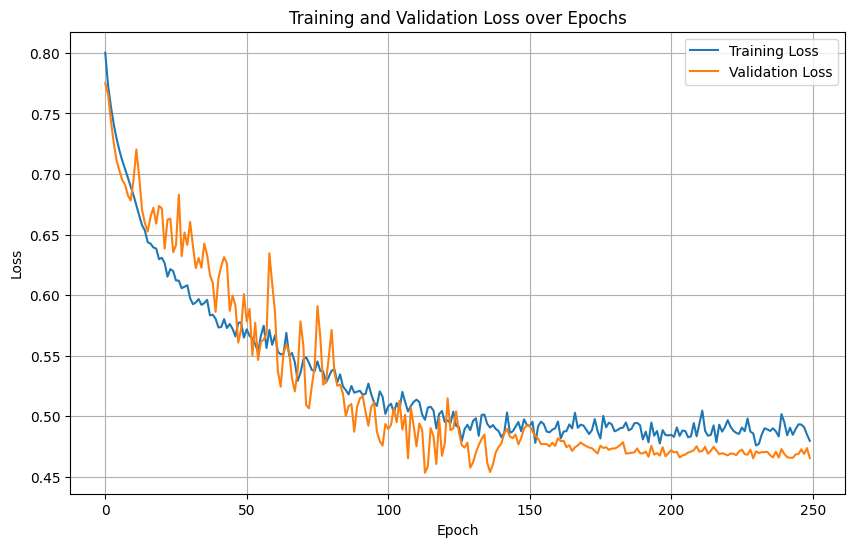

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Plot Dice Score over Epochs**

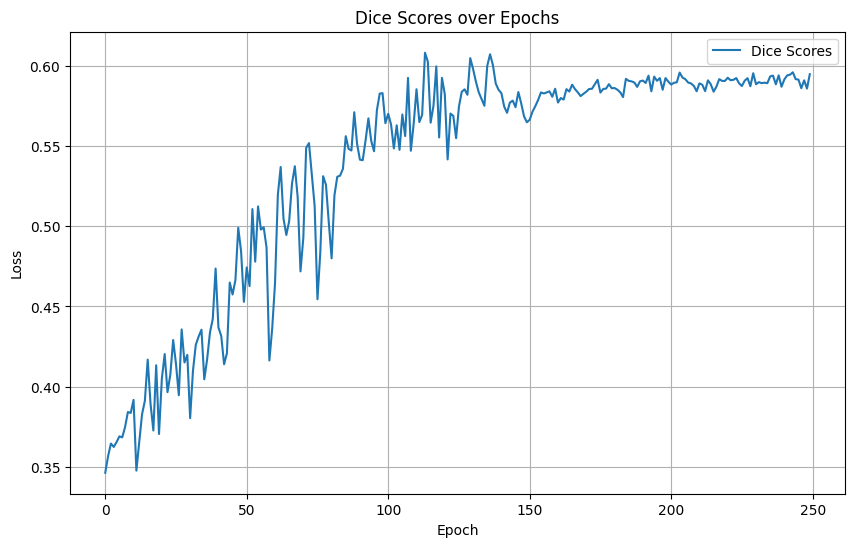

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(dice_scores)), dice_scores, label='Dice Scores')
plt.title('Dice Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Plot Predicted Samples**

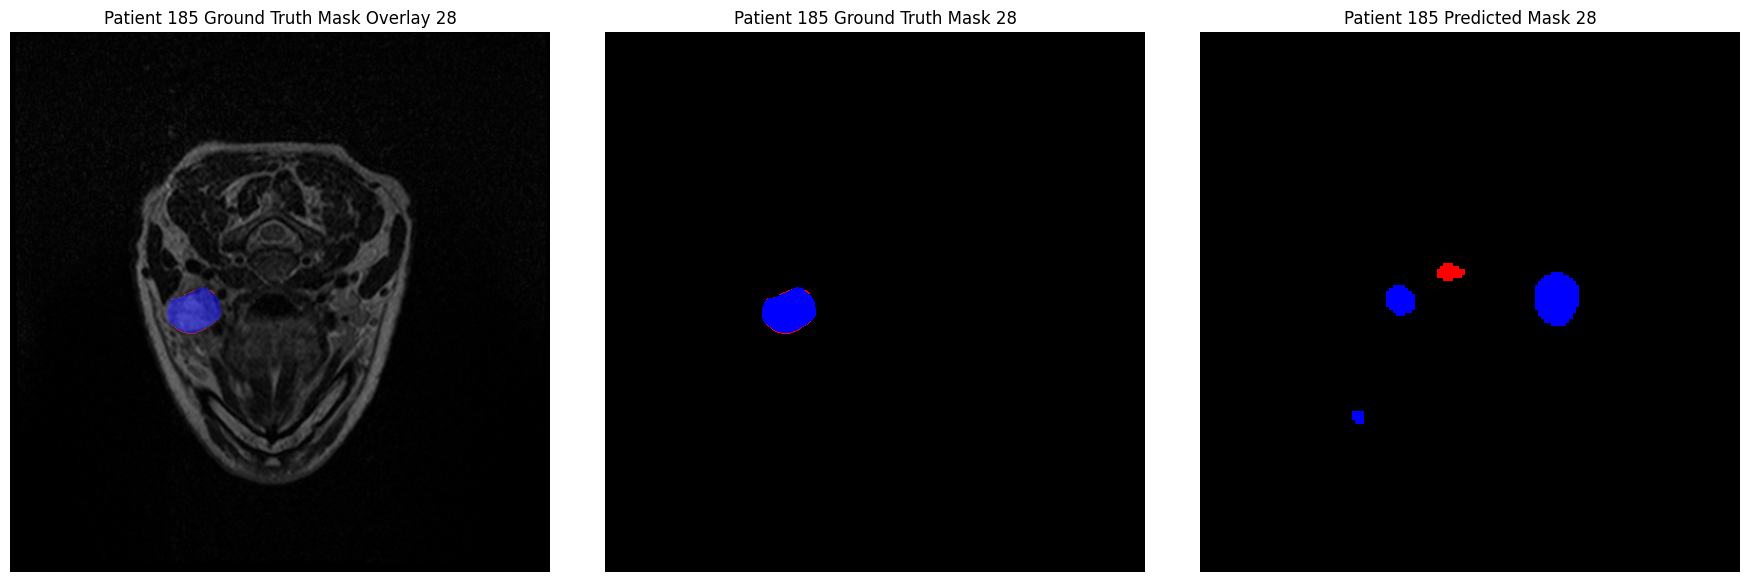

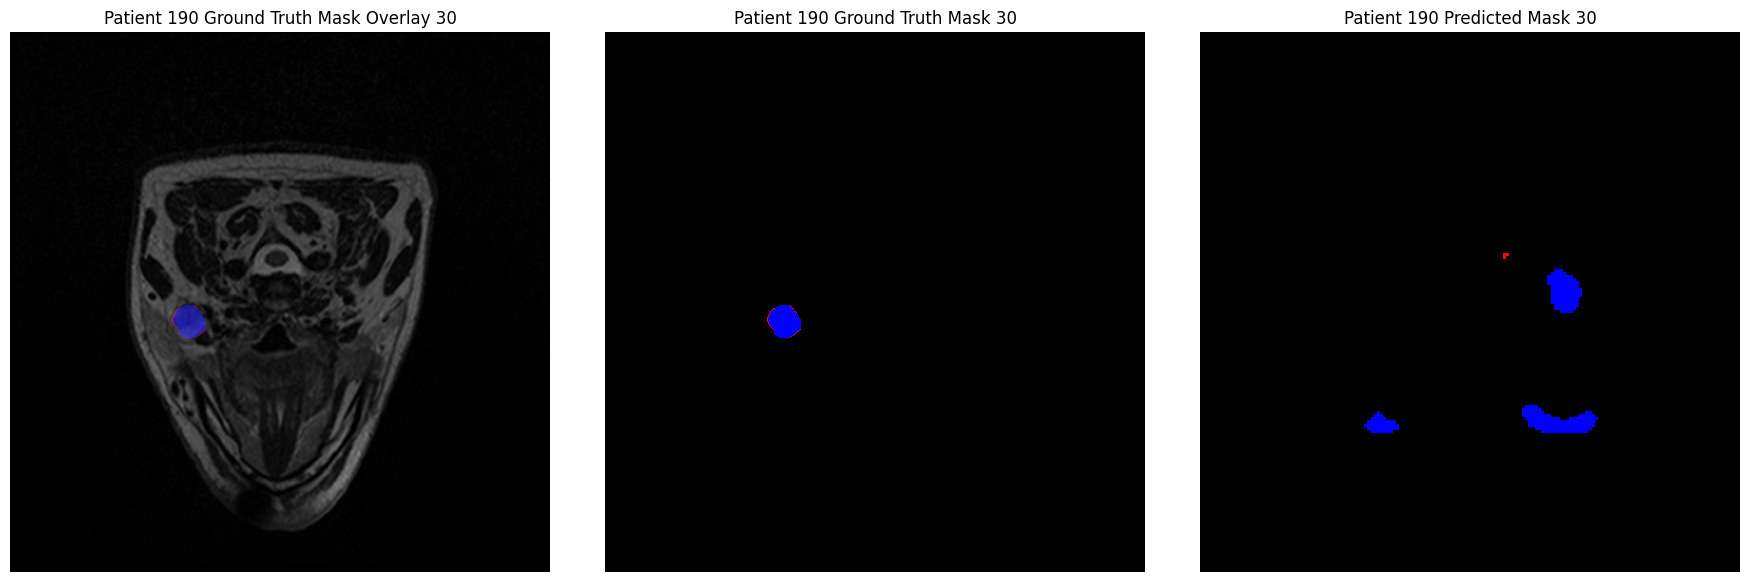

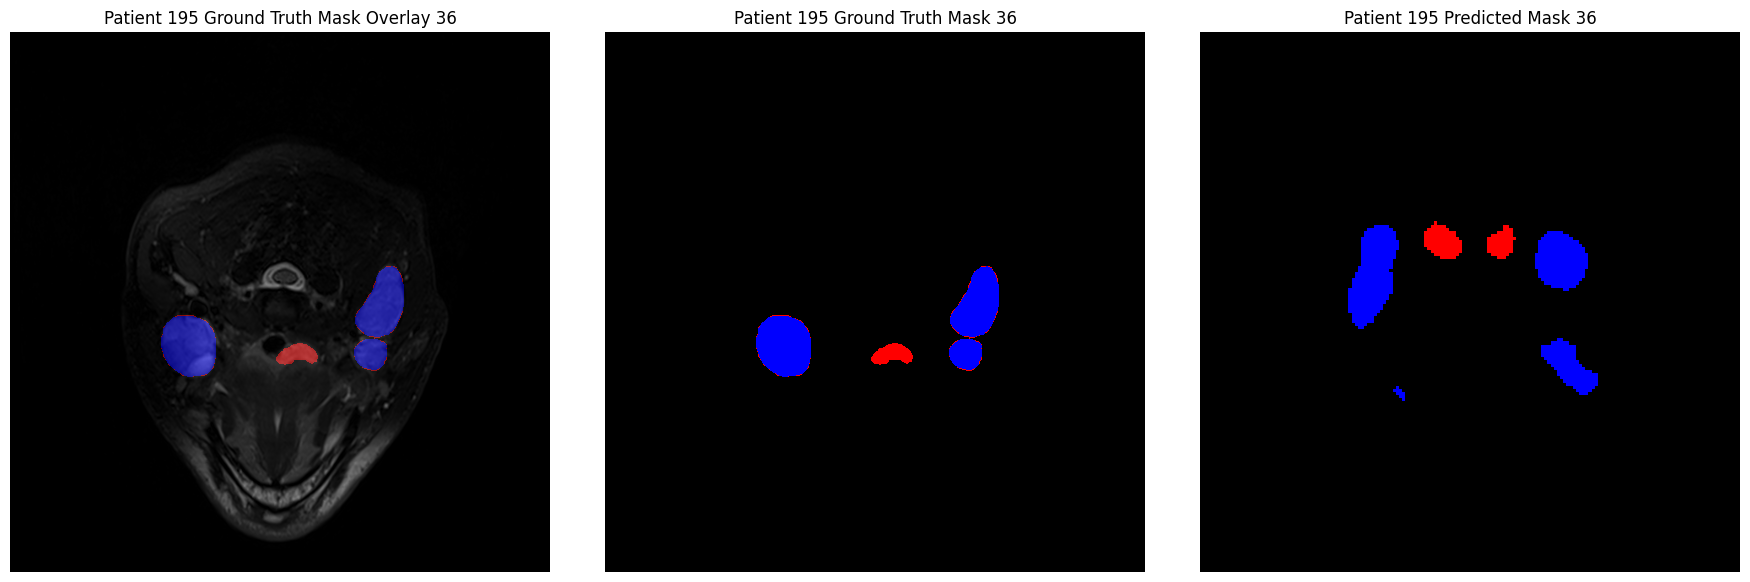

In [48]:
def plot_prediction(train_dir, val_transforms, model, patient_id, slice_index=None, device='cpu'):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select middle slice if not specified
    slice_index = slice_index or mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T

    # Preprocess and predict
    model.eval()
    with torch.no_grad():
        processed = val_transforms({"image": mri_path, "label": mask_path})
        with torch.amp.autocast(str(device)):
            input_tensor = processed["image"].unsqueeze(0).to(device)
            output = sliding_window_inference(input_tensor, (96, 96, 96), 4, model)
            probabilities = torch.softmax(output, dim=1)
            predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
    
    # Extract the predicted slice and transpose
    predicted_slice = predicted[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Ground Truth Mask Overlay
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[0].set_title(f'Patient {patient_id} Ground Truth Mask Overlay {slice_index}')
    axes[0].axis('off')

    # 2. Ground Truth Mask
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[1].set_title(f'Patient {patient_id} Ground Truth Mask {slice_index}')
    axes[1].axis('off')
    
    # 3. Predicted Mask
    axes[2].imshow(predicted_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Predicted Mask {slice_index}')
    axes[2].axis('off')
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Ensure the model is on the correct device
model.to(device)

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_prediction(TRAIN_DIR, val_transforms, model, patient_id=pid, device=device)